In [1]:
import numpy as np
import cntk as C
from cntk.io import UserMinibatchSource, StreamInformation, MinibatchData

In [2]:
from glob import glob
import re
import PIL as Image

In [20]:
lst = glob('gear_images_128x128_tst/*/*')

In [21]:
data = [(re.findall(r'(.*)\/(.*)\/([^\/]*)',f)[0][1], f) for f in lst]

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [22]:
le = LabelEncoder()

In [23]:
X_train_, X_test_, y_train_, y_test_ = train_test_split([x for x in data],[x[0] for x in data])

In [41]:
y_train = le.fit_transform(y_train_)
y_test = le.fit_transform(y_test_)

In [9]:
X_train = [np.array(Image.Image.open(x)).reshape(-1).reshape(-1) for x in X_train_]
X_test = [np.array(Image.Image.open(x)).reshape(-1).reshape(-1) for x in X_test_]

AttributeError: 'tuple' object has no attribute 'read'

In [24]:
dt_tr = [[x[1], x[0]] for x in X_train_]

dt_tr = np.array([np.array(x) for x in dt_tr])

dt_tr[:,1] = le.fit_transform(dt_tr[:,1])

# dt_tr.tofile('train.txt',sep="\t", format="%s\n")

with open('train.txt', 'w') as f:
    for x in dt_tr:
        f.write(str(x[0]) + "\t" + str(x[1]) + "\n")

In [25]:
dt_ts = [[x[1], x[0]] for x in X_test_]

dt_ts = np.array([np.array(x) for x in dt_ts])

dt_ts[:,1] = le.fit_transform(dt_ts[:,1])

#dt_ts.tofile('test.txt',sep="", format="\t%s\n")
with open('test.txt', 'w') as f:
    for x in dt_ts:
        f.write(str(x[0]) + "\t" + str(x[1]) + "\n")

In [4]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import PIL
import sys
try:
    from urllib.request import urlopen
except ImportError:
    from urllib import urlopen

import cntk as C

In [5]:
image_height = 128
image_width  = 128
num_channels = 3
num_classes  = 12

import cntk.io.transforms as xforms
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):
    print("Reading map file:", map_file)
    # print("Reading mean file:", mean_file)

    # if not os.path.exists(map_file) or not os.path.exists(mean_file):
    #     raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    
    """
    transforms = []
    # train uses data augmentation (translation only)
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    """
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=[]), # first column in map file is referred to as 'image' # ,transforms=transforms
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [6]:
data_path = ""

In [7]:
reader_train = create_reader(os.path.join(data_path, 'train.txt'),
                             os.path.join(data_path, 'cntk-train_a_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test.txt'),
                             os.path.join(data_path, 'cntk-test_a_mean.xml'), False)

Reading map file: train.txt
Reading map file: test.txt


In [11]:
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((5,5), 32, pad=True)(input)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 32, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
        
        net = C.layers.Convolution((5,5), 64, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
        
        net = C.layers.Dense(64)(net)
        net = C.layers.Dense(out_dims, activation=None)(net)

    return net

In [12]:
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var)

    # apply model to input
    z = model_func(input_var_norm, out_dims=12)

    #
    # Training action
    #

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)

    # training config
    epoch_size     = 100
    minibatch_size = 4

    # Set training parameters
    lr_per_minibatch       = C.learning_parameter_schedule([0.01]*10 + [0.003]*10 + [0.001],
                                                       epoch_size = epoch_size)
    momentums              = C.momentum_schedule(0.9, minibatch_size = minibatch_size)
    l2_reg_weight          = 0.001

    # trainer object
    #learner = C.momentum_sgd(z.parameters,
    #                         lr = lr_per_minibatch,
    #                         momentum = momentums,
    #                         l2_regularization_weight=l2_reg_weight)
    learner = C.sgd(z.parameters,lr=lr_per_minibatch)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count),
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far

            # For visualization...
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)

            batch_index += 1
        trainer.summarize_training_progress()

    #
    # Evaluation action
    #
    epoch_size     = 10
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")

    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0))
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0))

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width

    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()

    return C.softmax(z)

Training 1001772 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Finished Epoch[1 of 50]: [Training] loss = 2.418881 * 100, metric = 87.00% * 100 1.626s ( 61.5 samples/s);
Finished Epoch[2 of 50]: [Training] loss = 2.224711 * 100, metric = 66.00% * 100 1.132s ( 88.3 samples/s);
Finished Epoch[3 of 50]: [Training] loss = 2.312162 * 100, metric = 76.00% * 100 0.741s (135.0 samples/s);
Finished Epoch[4 of 50]: [Training] loss = 2.119567 * 100, metric = 71.00% * 100 0.703s (142.2 samples/s);
Finished Epoch[5 of 50]: [Training] loss = 2.044655 * 100, metric = 61.00% * 100 0.989s (101.1 samples/s);
Finished Epoch[6 of 50]: [Training] loss = 1.774274 * 100, metric = 61.00% * 100 0.569s (175.7 samples/s);
Finished Epoch[7 of 50]: [Training] loss = 1.447831 * 100, metric = 51.00% * 100 0.364s (274.7 samples/s);
Finished Epoch[8 of 50]: [Training] loss = 1.510182 * 100, metric = 46.00% * 100 0.312s (320.5 samples/s);
Finished Epoch[9 of 50]: [Training] loss = 1.327862 * 10

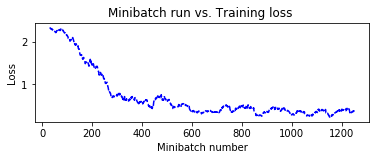

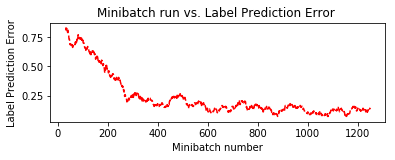

In [14]:
pred = train_and_evaluate(reader_train,
                          reader_test,
                          max_epochs=50,
                          model_func=create_basic_model)

In [15]:
pred

Composite(Softmax): Input('Input1055', [#], [3 x 128 x 128]) -> Output('Softmax1660_Output_0', [#], [12])

In [26]:
def eval(pred_op, image_data):
    label_lookup = le.classes_
    image_mean = 133.0
    image_data -= image_mean
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))

    result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

    # Return top 3 results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]

    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]] * 100))

In [27]:
img = Image.Image.open('gear_images_128x128_tst/gloves/10230884x1078391_zm.jpg')

In [28]:
img = np.array(img, dtype=np.float32)

In [29]:
eval(pred, img)

Top 3 predictions:
	Label: gloves    , confidence: 76.78%
	Label: boots     , confidence: 9.61%
	Label: pulleys   , confidence: 8.98%


In [32]:
def eval_one(pred_op, image_data):
    label_lookup = le.classes_
    image_mean = 133.0
    image_data -= image_mean
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))

    result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

    # Return top 3 results:
    # top_count = 3
    # result_indices = (-np.array(result)).argsort()[:top_count]
    return (-np.array(result)).argsort()[0]

In [33]:
eval_one(pred, img)

4

In [36]:
y_pred = []
for x in [ np.array(Image.Image.open(x[1]), dtype=np.float32) for x in X_test_]:
    y_pred.append(eval_one(pred, x))

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[12  0  3  3  1  0  1  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 69  1  0  0  0  1  0  1  0  0]
 [ 0  0  0 30  0  0  1  0  0  0  0  0]
 [ 0  1  0  0 48  0  0  0  1  0  0  0]
 [ 0  0  1  0  0 80  0  0 29  1  1  0]
 [ 0  0  1  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  1 10  0  0 58  0  0  0]
 [ 0  0  0  2  2  0  0  0  1  8  0  0]
 [ 0  1  0  0  3  0  2  0  0  0 37  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 32]]


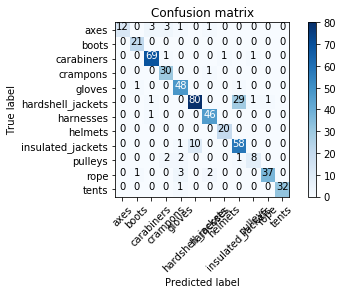

In [42]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), le.classes_);